# SQuAD-Question-Answering

## Install dependencies

We will be using the Transformers library from Hugging Face which will give us a pytorch interface for working with transformers. Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments.

hugs Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration between them. We will be using TensorFlow.

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import dependencies

In [2]:
import json
import transformers
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from datasets import Dataset
import collections
from transformers import AutoTokenizer
from transformers import DefaultDataCollator
from transformers import create_optimizer
from transformers import TFAutoModelForQuestionAnswering
from transformers import AutoConfig, TFAutoModel
from tqdm.auto import tqdm
from transformers import TrainingArguments, Trainer

from transformers import default_data_collator

### Google drive

In [3]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1BcEgcjOvTt6CsbycmBJhAFK9r3MkOnYO' #<-- You add in here the id from you google drive file


download = drive.CreateFile({'id': file_id})

In [5]:
tf.__version__

'2.8.2'

## Load data


Using Drive to load the json file containing the dataset, and check the version and the lenght.

In [6]:
json_file_input = 'training_set.json' # File name
file_input = download.GetContentFile(json_file_input)
input_data = pd.read_json(json_file_input)

print(f'The input dataset is SQUAD version {input_data["version"][0]}')
print(f'lenght input dataset: {len(input_data["data"])}')

The input dataset is SQUAD version 1.1
lenght input dataset: 442


An example of the structure of the json file. It's divided in **paragraphs**. Each paragraph has some **context** and each of them has **qas** field. In every qas there are **answers** (with the index where the **answer starts** and its **ID**) and the relative **questions**.

In [7]:
input_data["data"][0]

{'title': 'University_of_Notre_Dame',
 'paragraphs': [{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
   'qas': [{'answers': [{'answer_start': 515,
       'text': 'Saint Bernadette Soubirous'}],
     'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
     'id': '5733be284776f41900661182'},
    {'ans

## Splitting based on the title

We split the dataset into training and validation set (ratio 0.8 : 0.2) and with a loop we take every article, divide per paragraph and append the information from the json to the training and the validation set. For convenience we also save the entire answer, as well as the start index.

In [8]:
# Splitting the dataset into training and validation
split = 0.25 # Percentage for the validation + test
len_training = len(input_data['data']) * (1 - split)
len_valid = (len(input_data['data']) - len_training)//2.1

data_training = []
data_validation = []
data_test = []

# Splitting as suggested based on the title
for i, article in enumerate(input_data['data']):
    # article is a dictionary with keys: title, paragraphs
    title = article['title'].strip()

    for paragraph in article['paragraphs']:
        # paragraph is a dectionary with keys: context, qas
        context = paragraph['context'].strip()

        for qa in paragraph["qas"]:
            # qa is a dectionary with keys: answers, question, id
            question = qa["question"].strip()
            id_ = qa["id"]

            answer_starts = [answer["answer_start"] for answer in qa["answers"]]
            answers = [answer["text"].strip() for answer in qa["answers"]]

            if i <= len_training:
                data_training.append({'title': title,
                                    'context': context,
                                    'question': question,
                                    'id': id_,
                                    "answer_start": answer_starts[0],
                                    "answer_text": answers[0]
                                    })
            elif i > len_training and i < (len_training + len_valid):
                data_validation.append({'title': title,
                                    'context': context,
                                    'question': question,
                                    'id': id_,
                                    "answer_start": answer_starts[0],
                                    "answer_text": answers[0]
                                    })
                
            else:
                data_test.append({'title': title,
                    'context': context,
                    'question': question,
                    'id': id_,
                    "answer_start": answer_starts[0],
                    "answer_text": answers[0]
                    })

In [9]:
print(f"lenght training: {len(data_training)}")         
print(f"lenght validation: {len(data_validation)}")
print(f"lenght test: {len(data_test)}")

lenght training: 66230
lenght validation: 9369
lenght test: 12000


## Data Visualization

We are going to use Pandas to show some statistical references regarding the distributions of lengths between questions and answers and the distribution of the 8 WH question words

In [10]:
train_df = pd.DataFrame(data_training)
valid_df = pd.DataFrame(data_validation)
test_df = pd.DataFrame(data_test)
figsize = (10,6)
train_df

,title,context,question,id,answer_start,answer_text
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,515,Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,188,a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,279,the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181,381,a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e,92,a golden statue of the Virgin Mary
...,...,...,...,...,...,...
66225,Liberal_Party_of_Australia,A period of division for the Liberals followed...,What was the Australian unemployment rate in 1...,5728eb37ff5b5019007da945,233,11.4%
66226,Liberal_Party_of_Australia,A period of division for the Liberals followed...,What discussion proved an example of the diffi...,5728eb37ff5b5019007da946,1772,the infamous birthday cake interview
66227,Liberal_Party_of_Australia,"In South Australia, initially a Liberal and Co...",How long was Tom Playford in political power?,5728eb88ff5b5019007da94a,182,from the 1933 election to the 1965 election
66228,Liberal_Party_of_Australia,"In South Australia, initially a Liberal and Co...",How many consecutive losses has the Liberal pa...,5728eb88ff5b5019007da94b,874,a record five


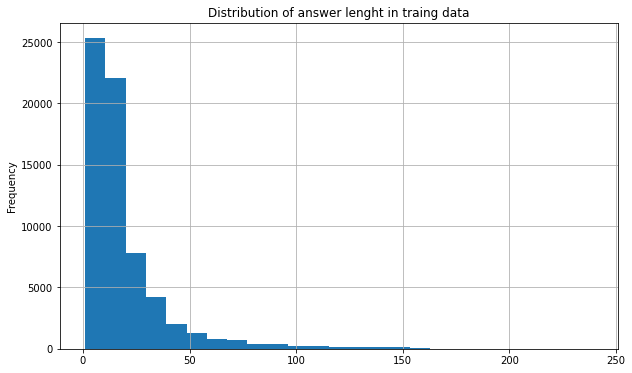

In [11]:
train_df['answer_text'].apply(len).plot.hist(title="Distribution of answer lenght in traing data", bins=25, figsize=figsize, grid=True)

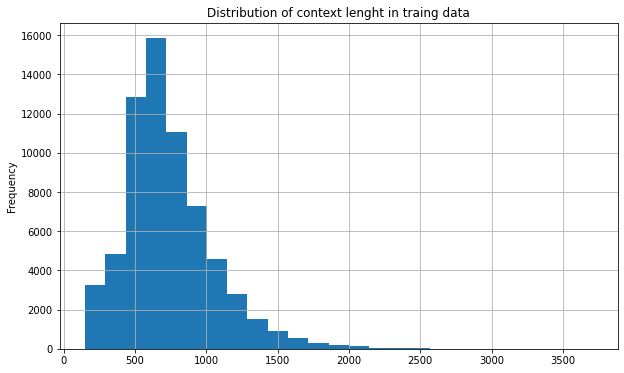

In [12]:
train_df['context'].apply(len).plot.hist(title="Distribution of context lenght in traing data", bins=25, figsize=figsize, grid=True)

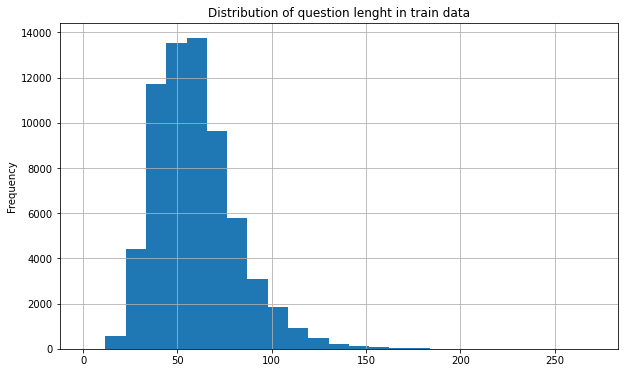

In [13]:
train_df['question'].apply(len).plot.hist(title="Distribution of question lenght in train data", bins=25, figsize=figsize, grid=True)

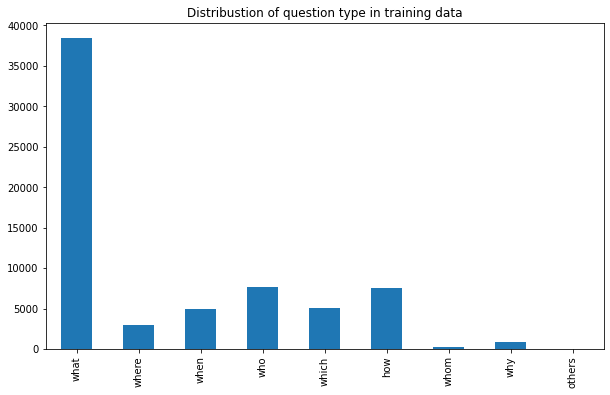

In [14]:
def find_question_type(df):
    len_df = len(df['question'])

    what = len(df[df['question'].str.contains('what', case=False, regex=False)]) 
    where = len(df[df['question'].str.contains('where', case=False, regex=False)]) 
    when = len(df[df['question'].str.contains('when', case=False, regex=False)]) 
    who = len(df[df['question'].str.contains('who', case=False, regex=False)]) 
    which = len(df[df['question'].str.contains('which', case=False, regex=False)]) 
    how = len(df[df['question'].str.contains('how', case=False, regex=False)])
    whom = len(df[df['question'].str.contains('whom', case=False, regex=False)])
    why = len(df[df['question'].str.contains('why', case=False, regex=False)])

    others = len_df - what - where - when - who - which - how - whom - why

    # In case of duplicates picked up by contains
    if others < 0:
        others = 0

    return what, where, when, who, which, how, whom, why, others

question_type = find_question_type(train_df)
plotdata = pd.DataFrame({"question": question_type}, index=["what", "where","when","who","which","how","whom", "why", "others"])
plotdata['question'].plot(kind="bar",title="Distribustion of question type in training data", figsize=figsize)

AutoTokenizer is a generic tokenizer class that will be instantiated as one of the tokenizer classes of the library when created with the AutoTokenizer.from_pretrained(pretrained_model_name_or_path) class method.

The from_pretrained() method takes care of returning the correct tokenizer class instance based on the model_type property of the config object, or when it’s missing, falling back to using pattern matching on the pretrained_model_name_or_path string:

In [15]:
model = "distilbert-base-uncased"
#model = "roberta-base"
#model = "distilroberta-base"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model)

## Preprocessing


In [17]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context).

In [18]:
max_len = 384
doc_stride = 128
pad_on_right = tokenizer.padding_side == "right"

In [19]:
def prepare_train_features(examples):
    inputs = tokenizer(examples["question" if pad_on_right else "context"],
                       examples["context" if pad_on_right else "question"],
                       truncation="only_second" if pad_on_right else "only_first",
                       max_length = max_len,
                       stride=doc_stride,
                       return_offsets_mapping=True,
                       padding="max_length")

    offset_mapping = inputs.pop("offset_mapping")
    answers_start = examples["answer_start"]
    answers_text = examples['answer_text']
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        start_char = answers_start[i]
        end_char = answers_start[i] + len(answers_text[i])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

For validation, we don’t need to compute start and end positions; instead, we’ll collect the examples that combine to make a feature. The sample_mapping key gives us the map that provides information on the correspondence between the context and the split features from it due to the max_length limit. We’ll take the sequence_ids to know where exactly the question and context lie in the sequences. The pad_to_right is True, so the context index will be 1. Lastly, we’ll be setting the offset_mapping to None that aren’t included in the context, making it simpler to detect the context.
https://medium.com/mlearning-ai/question-answering-in-association-with-roberta-a11518e70507

Use Datasets map function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting batched=True to process multiple elements of the dataset at once. Remove the columns you don’t need

In [20]:
train_tokenized_squad = train_dataset.map(prepare_train_features, 
                                          batched=True, 
                                          remove_columns=train_dataset.column_names)
valid_tokenized_squad = valid_dataset.map(prepare_train_features,
                                          batched=True,
                                          remove_columns=valid_dataset.column_names)

  0%|          | 0/67 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

## Train

### Parameters

In [21]:
batch_size = 32
num_epochs = 2
learning_rate = 0.0001
num_warmup_steps = 0

We use DefaultDataCollator to create a batch of examples. Unlike other data collators in Transformers, the DefaultDataCollator does not apply additional preprocessing such as padding.

In [22]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = train_tokenized_squad.to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

validation_set = valid_tokenized_squad.to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

In [31]:
total_train_steps = (len(train_tokenized_squad) // batch_size) * num_epochs

optimizer, schedule = create_optimizer(init_lr=learning_rate,
                                        num_warmup_steps=num_warmup_steps,
                                        num_train_steps=total_train_steps,)

# This is a generic model class that will be instantiated as one of the model classes of the library (with a question answering head)
qa_model = TFAutoModelForQuestionAnswering.from_pretrained(model)
qa_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 optimizer=optimizer, 
                 metrics=["accuracy"])

train_model = False

if train_model:
    qa_model.fit(train_set, validation_data=validation_set, epochs=num_epochs)
    qa_model.save_pretrained('.')
else:
    # file_id = '1-IUaTOzqE7s5yY2vigz3Kzp7qGYzDsJb' #<-- You add in here the id from you google drive file
    # download = drive.CreateFile({'id': file_id})
    # weights = download.GetContentFile('tf_model.h5')
    qa_model.load_weights('/tf_model.h5')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
qa_model.save_pretrained("/")

In [33]:
def prepare_test_features(examples):

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_len,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])]
            
    return tokenized_examples

In [35]:
test_features = test_dataset.map(
    prepare_test_features,
    batched=True,
    remove_columns=test_dataset.column_names)

test_ds = test_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator)

raw_predictions = qa_model.predict(test_ds)

  0%|          | 0/12 [00:00<?, ?ba/s]

https://github.com/huggingface/transformers/blob/57461ac0b4e4f7349c2437fcf8d4115014d6ceda/examples/pytorch/question-answering/utils_qa.py#L31

In [40]:
def postprocess_qa_predictions( 
    examples, 
    features, 
    all_start_logits, 
    all_end_logits, 
    n_best_size=20, 
    max_answer_length=30, 
): 
    # Build a map example to its corresponding features. 
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])} 
    features_per_example = collections.defaultdict(list) 

    for i, feature in enumerate(features): 
        features_per_example[example_id_to_index[feature["example_id"]]].append(i) 
 
    # The dictionaries we have to fill. 
    predictions = collections.OrderedDict() 
 
    print( 
        f"Post-processing {len(examples)} example predictions split into {len(features)} features." 
    ) 
 
    # Now we need to 
    for example_index, example in enumerate(tqdm(examples)): 
        # Those are the indices of the features associated to the current example. 
        feature_indices = features_per_example[example_index] 
 
        valid_answers = [] 
 
        context = example["context"] 
        # Looping through all the features associated to the current example. 
        for feature_index in feature_indices: 
            # We grab the predictions of the model for this feature. 
            start_logits = all_start_logits[feature_index] 
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original 
            # context. 
            offset_mapping = features[feature_index]["offset_mapping"] 
 
            # Update minimum null prediction. 
            cls_index = features[feature_index]["input_ids"].index( 
                tokenizer.cls_token_id 
            ) 
            feature_null_score = start_logits[cls_index] + end_logits[cls_index] 
            min_null_score = feature_null_score 
 
            # Go through all possibilities for the n_best_size greater start and end logits. 
            start_indexes = np.argsort(start_logits)[ -1 : -n_best_size - 1 : -1 ].tolist() 
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist() 

            for start_index in start_indexes: 
                for end_index in end_indexes: 
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond 
                    # to part of the input_ids that are not in the context. 
                    if ( 
                        start_index >= len(offset_mapping) 
                        or end_index >= len(offset_mapping) 
                        or offset_mapping[start_index] is None 
                        or offset_mapping[end_index] is None 
                    ): 
                        continue 
                    # Don't consider answers with a length that is either < 0 or > max_answer_length. 
                    if ( 
                        end_index < start_index 
                        or end_index - start_index + 1 > max_answer_length 
                    ): 
                        continue 
 
                    try: 
                         
                        start_char = offset_mapping[start_index][0] 
                        end_char = offset_mapping[end_index][1] 
                        valid_answers.append( 
                            { 
                                "score": start_logits[start_index] + end_logits[end_index], 
                                "text": context[start_char:end_char], 
                            } 
                        ) 

                    except IndexError: 
                        start_char = 0
                        end_char = 0 
                        valid_answers.append( 
                            { 
                                "score": 0, 
                                "text": context[start_char:end_char], 
                            } 
                        ) 
 
        if len(valid_answers) > 0: 
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[ 
                0 
            ] 
        else: 
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid 
            # failure. 
            best_answer = {"text": "", "score": 0.0} 
 
        predictions[example["id"]] = best_answer["text"] 
 
 
    return predictions 

In [41]:
final_predictions = postprocess_qa_predictions(test_dataset, 
                                               test_features, 
                                               raw_predictions["start_logits"], 
                                                raw_predictions["end_logits"])

with open('predictions.json', 'w') as json_file:
    json.dump(final_predictions, json_file)

Post-processing 12000 example predictions split into 12126 features.


  0%|          | 0/12000 [00:00<?, ?it/s]